# modERN
For the tidiness of the code the used functions are stored in external modules which will be properly recalled when in use.

In [19]:
# Import useful library

from graviz import graph_processing
from graviz import wordclouds
import pandas as pd
from sklearn import datasets, linear_model
from collections import defaultdict
from wordcloud import WordCloud
from crawl_infoscience import *
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from BuildGraphModule import *
from scipy.misc import imread
from AnalysisModule import *
from UniformData import *
from MultiGraph import *
from GraphPlot import *
import community as com
import networkx as nx
import collections
import numpy as np
import requests
import pickle
import json

%matplotlib inline

## Data acquisition
The entire dataset has been scraped from Infoscience website. We run from the console a spider which just crawls and saves each html pages of interest. The number of total pages, each corresponding to a publication was 222,906. The crawling function has been written in order to be able to stop the operation and restart from the last checkpoints. In particular, we used a simple spider using `scrapy` library to speed up the downloads. The process to crawl was simple since the only parameter that changes in the urls is the number of the page which, luckily, goes from 1 to the last uploaded publication.

*Remark*: We wrote two functions to crawl the website, we show you the one we implemented [`crawl_infoscience.py`](crawl_infoscience.py) because (@CriMenghini) lost the `.py` file containing the spider.

In [ ]:
# fetch_html_infoscience(PATH TO STORE HTMLs, delay=1, error=False)

## Parse `html` sources
To parse the `html` sources we provide a `.py` file which parallelize the work and that should be run from the terminal (entering the path of the folder which contains the html sources). It save the parsed information into a `JSON` file. The class used by the file is stored in [`ParseInfoscience.py`](ParseInfoscience.py).

The function `parse_html` from the class `InfoscienceParser` returns a dictionary with the following possible instances: `Abstract`, `Title`, `Date of publication`, `Authors`, `Epfl authors`, `Involved Labs`, `Keywords`. 

__*Remark*__: not all the papers contain the same information. It is important to recall since it is kind of inconsistency problem that may imply variations in the obtained results according to filters applied on the data.

## Analysis

### Built Graph
We proceed building the Epfl Researchers Network. In particular we create an undirected graph characterized by the following structure:

* Nodes: authors of publications
* Edges: (u,v) if a coauthorship relation stands between u and v
* Weights: (u,v,w) where the weight corresponds to the number of common publications between u and v

##### Load data: 

The loaded data are in the following form. To remind:

                               {ID_paper_1:{'Abstract': 'text', 
                                            'Title' : 'title', 
                                            'Date of publication' : '1999', 
                                            'Authors' : [a1, a2, a3], 
                                            'Epfl authors' : [{'name_author':'web_page'}], 
                                            'Involved Labs' : [{'name_lab' : 'lab_web_site'}], 
                                            'Keywords' : [k1, k2, k3]}
                                            
    
*_Remark_*: due to the fact that the web pages don't always contain all the information, the dictionary related to each paper may vary. It implies that for the further analysis it may happen that the number of publications taken into account will vary according to the information it relies on.

In [2]:
with open('paper.json', 'r') as f:
    data = json.load(f)

Decode authors name in order to get rid of duplicates due to spell differences. The used fuctions are store in the module [`UniformData.py`](UniformData.py).

In [3]:
# Uniform strings - Authors
data = uniform_authors(data)

In [4]:
# Uniform strings - EPFL Authors
data = uniform_epfl_authors(data)

#### General graph
 Before getting focused on the EPFL network, we built a graph that includes also the external researchers. The functions used in this section are stored in the module [`BuildGraphModule.py`](BuildGraphModule.py).

In [5]:
# Define the list of authors
authors = get_authors(data, 'Authors')

In [6]:
# Obtain dictionary which connect authors to an identification number (and the reverse)
dictionary_a_id, dictionary_id_a = create_authors_id(authors, 'all')

In order to define the graph, for each author we provide the list of people he collaborates with.

In [7]:
# Define the dictionary (author, list collaborators)
dict_authors = list_coauthors(data)

 For each author we count the number of collaborations with the same colleague.

In [8]:
# Compute the dictionary (author, dict(collaborator: number of common publication))
dict_numb_coll = number_collaborations(dict_authors)

Keep only the set of collaborators

In [9]:
# Define the dictionary (author, set of collaborators)
dict_authors_set = set_coauthors(dict_authors)

Thus, define the edges of the graph.

In [10]:
# Create edges
edges = create_edges(dict_authors_set, dictionary_a_id)

In [11]:
G = create_simple_graph(dictionary_id_a, edges)

Name: 
Type: Graph
Number of nodes: 161431
Number of edges: 17345810
Average degree: 214.9006


#### EPFL graph

We built the EPFL network repeating the same aforementioned operations. The graph is trimmed by using only `Epfl authors`.

In [12]:
authors_epfl = get_authors(data, 'Epfl authors')
# Due to the format which the authors have been saved

# We initialize a new list
epfl_authors = []

# Then for each element in the previous list
for i in authors_epfl:
    # We unpack the content
    epfl_authors += list(i.keys())

In [13]:
# Id-Author / Author-ID
dictionary_a_id_epfl, dictionary_id_a_epfl = create_authors_id(epfl_authors, 'epfl')

In [14]:
# EPFL - coauthors
dict_authors_epfl = list_coauthors_epfl(data)

In [15]:
# Number of collaborations
dict_numb_coll_epfl = number_collaborations(dict_authors_epfl)

In [16]:
# Coauthors set
dict_authors_set_epfl = set_coauthors(dict_authors_epfl)

In [17]:
# Set of edges
edges_epfl = create_edges(dict_authors_set_epfl, dictionary_a_id_epfl)

In [18]:
# Build the graph
G = create_simple_graph(dictionary_id_a_epfl, edges_epfl)

Name: 
Type: Graph
Number of nodes: 13451
Number of edges: 45417
Average degree:   6.7530


In [20]:
# Save the graph
graph_processing.save_graph(G, 'graph.json', representation='JSON')

Comparing the dimension and the composition of the two built network, the one made up by only EPFL researchers is:

* Almost ten times smaller in terms of authors, for each EPFL author there are 9 from another university. 
* The number of connections between authors is drastically reduced. It may be explaind by the fact that, due to the fact that the *external* (no EPFL) nodes are a way more than the *internal* (EPFL), the probability of having a connection with someone in the graph is higher, hence we obtain more edges.
* The number of average degree, which represents the average number of people any authors collaborate with, in the entire graph is high (214), and is 35 times bigger than the one in the EPFL network. It is interesting, since it may be said that the community research connected to EPFL is international, it is because most of the collaborators are from outside EPFL.

In [21]:
# Add weights to the edges
for i,j in G.edges():
    G[i][j]['weight'] = dict_numb_coll_epfl[dictionary_id_a_epfl[i]][dictionary_id_a_epfl[j]]

### EPFL Graph measures 
We are now going to compute some coefficients that may give us an idea of the structure of the graph.

#### Degree distribution
The degree of a node (author) in our network corresponds to the number of authors the node has collaborated with. The degree distribution is the probability distribution of these degrees over the whole network. 

In [22]:
G_deg = G.degree(G.nodes())
G_deg_values = sorted(G_deg.values(), reverse = True)

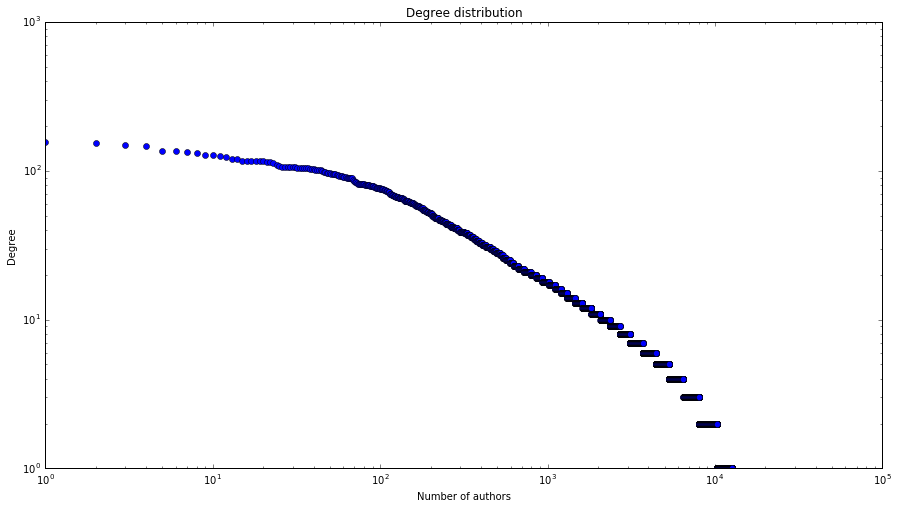

In [23]:
plot_measures(G_deg_values, 'Degree distribution', 'Number of authors', 'Degree', 'degree_distribution')

We see that only few authors have a really high number of connection, a lot of them just less than 10 connections (that's why the average results to be around 6).

#### PageRank centrality
The PageRank allows us to identify the most important authors in the network. It is a probability distribution used to represent the likelihood that we are able to randomly arrive at any particular author.

In [24]:
pr_centrality = nx.pagerank(G)
tuples_pr = pr_centrality.items()
pr_sorted = sorted(pr_centrality.values(),reverse = True)

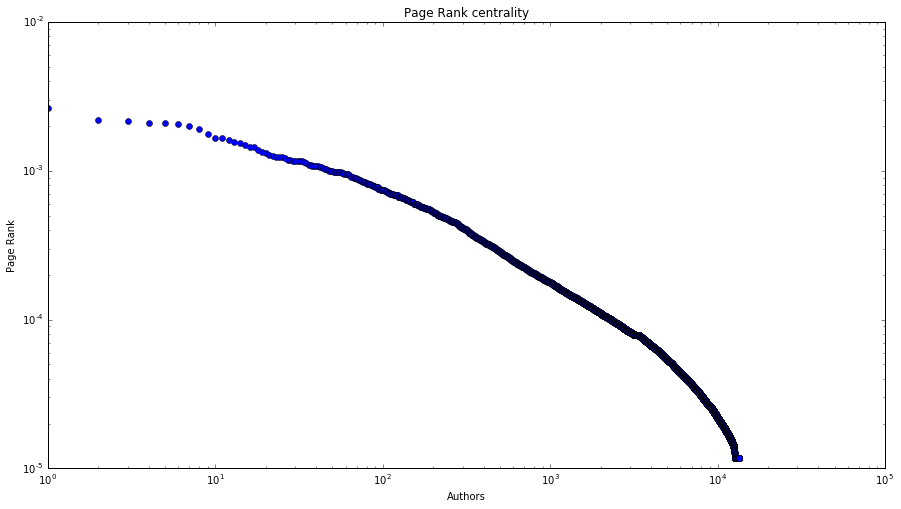

In [25]:
plot_measures(pr_sorted, 'Page Rank centrality', 'Authors', 'Page Rank', 'page_rank_centrality')

The distribution seems to be like the Zipf's law. Few have considerably high probability respect the other nodes. We don't prove it, it should have been done using the Kolmogorov-Smirnov test. The number of authors that have high probability of being reached from the others are few. We extract the 10 most important. 

*__Remark__*: we run on the EPFL the PageRank making the assumption that the graph is complete. Anyway interpreting the top authors as the most important, we should keep in mind that the obtained values may be dependent on the exclusion of *external* EPFL authors. 

##### Top 10 authors according to the PageRank

In [26]:
# Sort the PageRank values
pr_centralities_sorted = sorted(tuples_pr, key = getKey)
# Keep the best 10
top_10_pr_centr = pr_centralities_sorted[-10:]

In [27]:
# Get the list of the name
list_top_ten = []
for i in top_10_pr_centr:
    # Append element to the list
    list_top_ten += [dictionary_id_a_epfl[i[0]]]

The following list of name corresponds to the top 10 authors. It goes from the 10th to the first.

In [28]:
list_top_ten

['renaud philippe',
 'aberer karl',
 'thiran jean-philippe',
 'de micheli giovanni',
 'leblebici yusuf',
 'vetterli martin',
 'perriard yves',
 'marechal francois',
 'schleiss anton',
 'graetzel michael']

#### Average clustering coefficient
How much, on average, authors tend to create groups characterised by a relatively high density of edges.

The average clustering coefficient results to be quite high, moreover it is a way bigger than that obtain from a random graph.

In [29]:
avg_coeff = nx.average_clustering(G)
avg_coeff

0.5448363209546232

#### First observation about the structure of the Epfl Researchers Network

The ERN is a __*small-world*__: most researcher have not collaborated together, but the co-authors of any given researcher are likely to be co-authors of each other (avg clustering coef). Moreover, most authors can be reached from every other by a small number of hops (average short path).

#### Before analysing

We retrive the range of year we are working with.

In [30]:
# Get the range of years
dict_years = defaultdict(int)
# For each paper
for paper in list(data.keys()):
    # Whether the paper instance has the date specified
    try:
        dict_years[data[paper]['Publication date']] += 1
    # If not go on
    except:
        continue

In [31]:
# Get rid of the unidentified years
del dict_years['August 31-September 2 2005']
del dict_years['0']

We thake a brief look at the paper distribution over the entire period.

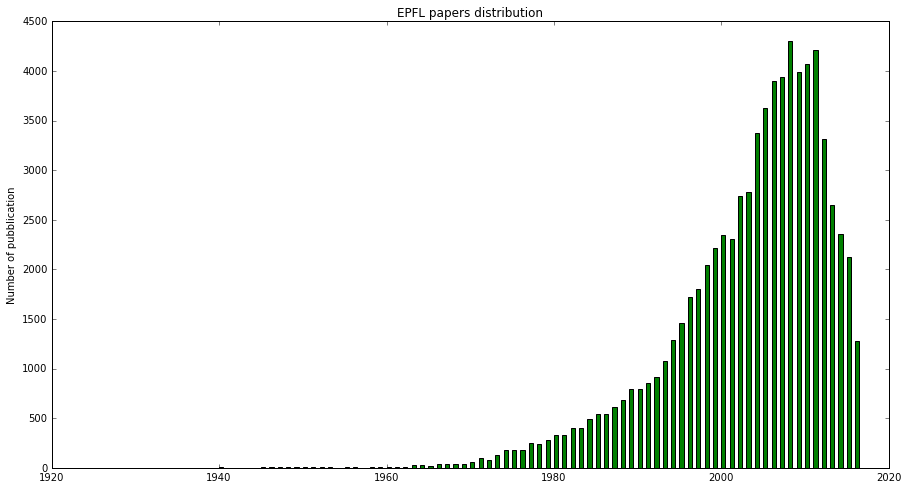

In [32]:
plt.figure(figsize=(15,8), dpi=80)
plt.bar(dict_years.keys(), dict_years.values(), 0.5, color='g')
plt.ylabel('Number of pubblication')
plt.title("EPFL papers distribution")

After a first glance twe observe that:
* The oldest publications are those which may contain fragmented and incomplete information
* The number of publication in considerably higher from the latest 90s to nowdays

As consequence we decide to focus our attention on the publications between 1993 and 2015/6. The function in use is stored in [`MultiGraph.py`]() module.

In [33]:
# Hence, we cut the data we work on
data_cut = cut_data(data)

Regarding the selected data, we observe the during the last years the production of paper is reducing. The plausible explanation for this phenomenon is that the EPFL is aiming to an higher quality production insted of a quantitative one.

#### Further data gaining
In order to explore the ERN such that interaction between schools and labs is possible, we should proceed scraping the specific lab an author belongs to and the school a lab is part of.

##### A. Scrape EPFL structure
* We scrape the EPFL structure from the EPFL website, which result to have a tree structure.

In order to speed up the operations, before traverse the tree, we reduce the branches to explore just selectiong the school's ones.

* From the root of the tree (EPFL) we extract the urls related to the schools. In particular we consider:
 - ENAC: SCHOOL OF ARCHITECTURE, CIVIL AND ENVIRONMENTAL ENGINEERING
 - IC: SCHOOL OF COMPUTER AND COMMUNICATION SCIENCES
 - STI: SCHOOL OF ENGINEERING
 - SB: SCHOOL OF BASIC SCIENCES
 - SV: SCHOOL OF LIFE SCIENCE

In [34]:
# From the root (EPFL): obtain the first level of the tree (schools)

#req = requests.get('https://search.epfl.ch/ubrowse.action?acro=EPFL')
#html = req.content
#soup = BeautifulSoup(html, 'html.parser')

# Get the urls for the schools

#new_links_to_go = []
#dictio = []
# Go to the second level of the tree
#for i in soup.findAll('div', {'class':'unit_name'}):
    # Keep only the schools
#    if i.findAll('a')[0].text.strip()[:6] == 'School':
#        new_links_to_go += [i.findAll('a')[0].get('href')]
#        dictio += [i.findAll('a')[0].text.strip()]

* So, for each school we traverse the tree until the labs level. To do so we use the function `tracerse_epfl_tree` stored in module [`MultiGraph.py`]().

In [35]:
#prova = {}
#traverse_epfl_tree('https://search.epfl.ch/ubrowse.action?acro=IC')

* The data is dumped in separate file for each school.

In [36]:
# Store the result related to each different school
#pickle.dump(prova, open('IC.p', 'wb')) 

Then, to each lab we connect the school.
1. Get informations about the labs
2. Connect 

In [37]:
# We built three different dictionary that may be used later. The function documentation provides informations about
dict_lab_site, dict_labs, dict_labs_paper = lab_dictionaries(data_cut)

###### Top 10 labs in according to the number of pubblications

In [38]:
dict_labs_sorted = sorted(dict_labs.items(), key=lambda value: value[1], reverse = True)

In [39]:
dict_labs_sorted[:10]

[('Swiss Plasma Center', 3344),
 ('Center for Research In Plasma Physics', 3221),
 ('Offered in consultation at the EPFL Library', 1622),
 ("L'IDIAP Laboratory", 1376),
 ('Transportation and Mobility Laboratory', 1186),
 ('Human and social sciences teaching program', 1146),
 ('Sensors, Actuators and Microsystems Laboratory', 1085),
 ('Urban Sociology Laboratory', 825),
 ('Electromagnetics and Acoustics Laboratory', 808),
 ('Laboratory of Photonics and Interfaces', 764)]

* Connect lab to school. Function `school_lab` stored in [`MultiGraph.py`]() module.

In [40]:
#lab_school = school_lab(dict_lab_site, 'IC')

##### B. Get lab for each author
We retrieve the labs of authors using this logic: whether only one lab is mentioned on InfoScience page, the EPFL authors are assumed to belong to that lab. Whether more than one lab is involved, we scrape the People page of the author. This procedure can lead to loosing some information since the pages of authors that are no more part of the EPLF have no longer the page on People.

In [41]:
# Get the dictionary (author, list collaborators with info)
dict_authors_epfl = get_collaborators(data)

In [42]:
# Get the dictionary (author, dict(collaborator,list of common works))
dict_coautorship_papers = coauthorship_papers(dict_authors_epfl)

In [43]:
# Define the dictionary (authos, set of papers)
list_paper = paper_per_author(dict_coautorship_papers)

Apply the function ([`MultiGraph.py`]()) to have the correspondence. And store what obtained.

In [44]:
#author_lab = get_authors_lab(list_paper, data)[0]
#pickle.dump(author_lab, open('author_lab.p', 'wb')) # Store the variable in a file.

In [45]:
lab = pickle.load(open('author_lab.p', 'rb'))

* Little example of what we get

In [46]:
lab['catasta michele']

'Distributed Information Systems Laboratory'

## School growth over the years

Then, we focus on how:
* The number of publication varies across the years 
* The rate of publication for each school across years

In [47]:
# Get the list of paper lab and year. Dictionary (lab, dict(year, list of papers))
dict_lab_years_pub = lab_year_pub(dict_labs_paper, data_cut)

In [48]:
# Dictionary (year, total number of papers)
year_papers = year_papers_(dict_lab_years_pub)

In [49]:
dict_author_year = lab_author_year(dict_lab_years_pub, data_cut)

In [50]:
# Get dictionary (lab, dict(year,num of pubblication))
dict_lab_years = lab_year(dict_labs_paper, data_cut)

In [51]:
# Dictionary (year, number of authors)
year_authors = year_auth(dict_lab_years)

We represent the distribution of publication between 1993-2016.

__*Remark*__: The number are different from the previous plot since we filter them by lab and not every paper has the attribute labs.

In [52]:
y,x = get_sorted_array(year_papers)
ind = np.arange(1993,2017)

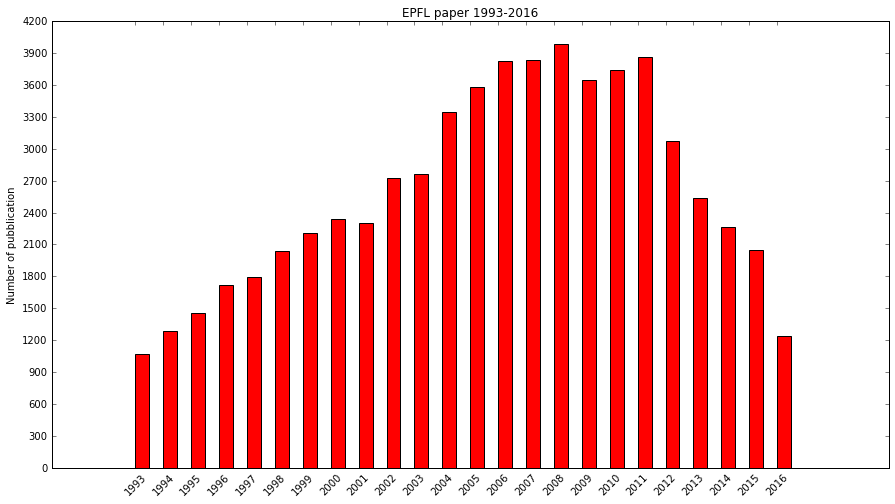

In [53]:
plt.figure(figsize=(15,8), dpi=80)
plt.bar(x, y, color = 'r', width=0.5)
plt.ylabel('Number of pubblication')
plt.title("EPFL paper 1993-2016")
plt.xticks(ind, np.arange(1993,2017), rotation = 45)
plt.yticks(np.arange(0, 4300, 300))
plt.savefig('epfl_activity.png', dpi=100)

We observe that in the last years the number of publication is reduced. We think that it may depends on the fact that the EPFL chooses to focus on the publication of works of high quality instead of working on the quantity of produced papers.

In [54]:
list_schools = ['ENAC', 'SB', 'IC', 'STI', 'SV']
dict_school_pub = {}
dict_school_authors = {}

In [55]:
# Dictionary (School, dict(year, number of publication))
for school in list_schools:
    sc_labs = school_lab(dict_lab_site, school)
    dict_school_pub = school_publication(sc_labs, school, dict_lab_years, dict_school_pub)

* Compute the total number of publications per year

In [56]:
total_year = defaultdict(int)
for school in list_schools:
    for year in list(dict_school_pub['ENAC'].keys()):
        total_year[year] += dict_school_pub[school][year]

* Get the numbers to plot

In [57]:
ENAC_scaled = get_sorted_array_scaled(dict_school_pub, 'ENAC', total_year)[0]
IC_scaled = get_sorted_array_scaled(dict_school_pub, 'IC', total_year)[0]
SV_scaled = get_sorted_array_scaled(dict_school_pub, 'SV', total_year)[0]
SB_scaled = get_sorted_array_scaled(dict_school_pub, 'SB', total_year)[0]
STI_scaled = get_sorted_array_scaled(dict_school_pub, 'STI', total_year)[0][:-1]

* Plot results

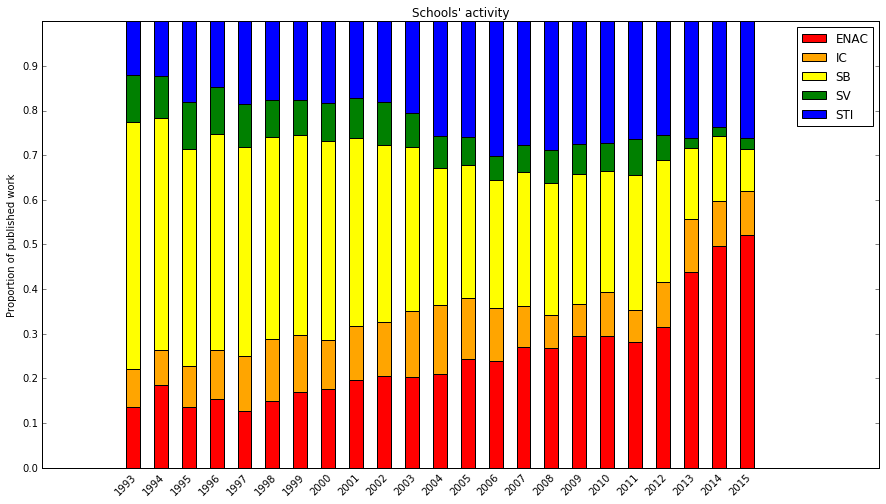

In [58]:
# Number of years
N = 23
# Lables for x-axis
ind = np.arange(1993,2016)
width = 0.5 
# Colors
colours = ['Red','Darkred','Pink','Blue','Lime']

# Define the bars
plt.figure(figsize=(15,8), dpi=80)
p1 = plt.bar(ind, ENAC_scaled, width, color = 'red')
p5 = plt.bar(ind, IC_scaled, width, bottom=ENAC_scaled, color = 'orange')
p4 = plt.bar(ind, SB_scaled, width, bottom=[i+j for i,j in list(zip(ENAC_scaled, IC_scaled))], color = 'yellow')
p2 = plt.bar(ind, SV_scaled, width, bottom=[i+j+k for i,j,k in list(zip(ENAC_scaled, IC_scaled, SB_scaled))], color = 'green')
p3 = plt.bar(ind, STI_scaled, width, bottom=[i+j+k+l for i,j,k,l in list(zip(ENAC_scaled, IC_scaled, SB_scaled,SV_scaled))], color = 'blue')

# Make the legend
plt.legend((p1[0], p5[0], p4[0], p2[0], p3[0]), ('ENAC', 'IC', 'SB', 'SV', 'STI'))

# Define titles
plt.ylabel('Proportion of published work')
plt.title("Schools' activity")
plt.xticks(ind, np.arange(1993,2016), rotation = 45)
plt.yticks(np.arange(0, 1, 0.1))
plt.savefig('school_activity_scaled.png', dpi=100)

Following this graph, we can see that ENAC school has the lead over the rest of the schools, one notable fact is that IC school productivity isn't very high and stays constant over the year, this may be counter intuitive regarding the fact that IC research is booming these last years.

In [59]:
# Dictionary (School, dict(year, number of authors))
for school in list_schools:
    sc_labs = school_lab(dict_lab_site, school)
    dict_school_authors = school_author(sc_labs, school, dict_author_year, dict_school_authors)

Then, we look for a relation between the number of authors and the number of publications.  

In [60]:
ratio_productivity = []
for school in list_schools:
    for year in list(dict_school_authors[school].keys()):
        try:
            ratio_productivity += [(dict_school_pub[school][year],dict_school_authors[school][year])]
        except:
            continue    

In [61]:
# Define a df
df = pd.DataFrame(ratio_productivity, columns=['Publications', 'Authors'])

* Take a look at the data: it seems that a linear relation may be found

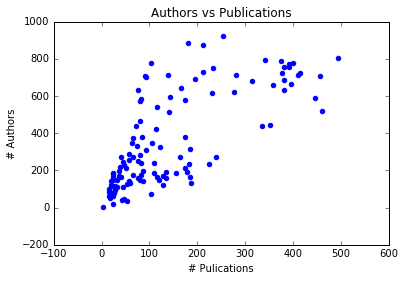

In [64]:
plt.scatter(df['Authors'], df['Publications'], marker='o', color='b')
plt.ylabel('# Authors')
plt.xlabel('# Pulications')
plt.title("Authors vs Publications")
#plt.xticks(ind, np.arange(1993,2016), rotation = 45)
#plt.yticks(np.arange(0, 1, 0.1))
plt.savefig('school_activity_scaled.png', dpi=100)

We'll try to fit a linear model to validate our claim.

In [65]:
# Define the regressor
regr = linear_model.LinearRegression()

In [66]:
# Fit the regressor on data
regr.fit( df['Authors'].to_frame(), df['Publications'].to_frame())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

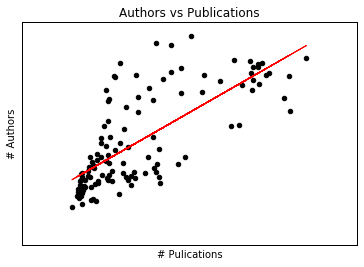

In [67]:
# Plot the fit
plt.scatter(df['Authors'].to_frame(), df['Publications'].to_frame(),  color='black')
plt.plot(df['Authors'].to_frame(), regr.predict(df['Authors'].to_frame()), color='red', linewidth=1)
plt.xticks(())
plt.yticks(())
plt.ylabel('# Authors')
plt.xlabel('# Pulications')
plt.title("Authors vs Publications")
plt.show()

In [68]:
# Correlation coefficient
regr.score(df['Authors'].to_frame(), df['Publications'].to_frame())

0.54510605590358618

The overall coefficient is not so high, but what we see is that the correlation between the two variables varies according to the school we take into consideration. In particular, all the school, except ENAC, have a linear correlation between 0.78 and 0.91 (IC school).

### Internationality

The goal of the whole project is to analyse the well-being of the research community at EPFL. A great sign of healthiness for research is the crossing of boundaries such as domain (we'll see later about this) and frontiers. In this part, we'll look more closely at the relation the research community of EPFL has with the international research community. The idea to compute such measure is to look at the ratio between the number of EPFL authors/co-authors compared to the total number of authors/co-authors of each paper. This will give us an insight about how open EPFL is in its research throughout the years.

In [69]:
# Get the range of years
dict_years = defaultdict(int)
#Get the total number of authors per year
dict_year_authors = defaultdict(float)
#Get the total number of EPFL authors per year
dict_year_epfl_authors = defaultdict(float)
dict_authors = defaultdict(float)
for paper in list(data.keys()):
    #First try block, in case we do not find the year of a paper, we just pass.
    try:
        #print (paper['Publication date'])
        dict_years[data[paper]['Publication date']] += 1
        dict_year_authors[data[paper]['Publication date']] += len(data[paper]['Authors'])
        dict_year_epfl_authors[data[paper]['Publication date']] += len(data[paper]['Epfl authors'])
        
    except:
        pass
    #Second try block where we attempt to fetch the EPFL authors of the paper.
    try:
        for author in data[paper]['Epfl authors']:
            dict_authors[author.keys()[0]] += 1
    except:
        continue

Get rid of outliers, corrupted data and incomplete results

In [70]:
dict_year_authors.pop('0', None)
dict_year_authors.pop('August 31-September 2 2005', None)
dict_year_authors.pop('2017', None)

12.0

Normalize the internationality measure

In [71]:
#Helper function for normalizing dicts
def normalize_dict(d):
    factor=1.0/sum(list(d.values()))
    for k in d:
        d[k] = d[k]*factor
    return d

We want to get a meaningful idea over the internationality of EPFL research, by only computing the ratio aforementioned, we wouldn't seize the augmentation of the number of paper puplished in the last 20 years. In order to get better results, we multiply the previously obtained internationality ratio by the normalized number of publications in the corresponding year.

In [72]:
#Compute the internationality measures
open_measure = defaultdict(float)
open_measure_scaled = defaultdict(float)
for year in list(dict_year_authors.keys()):
    #Without scaling by the number of publications
    open_measure[year] = (dict_year_epfl_authors[year] / dict_year_authors[year])
    #With scaling of the publications
    open_measure_scaled[year] = (dict_year_epfl_authors[year] / dict_year_authors[year])*dict_years[year]

In [73]:
def getKey(item):
    return item[0]

Plotting of our results

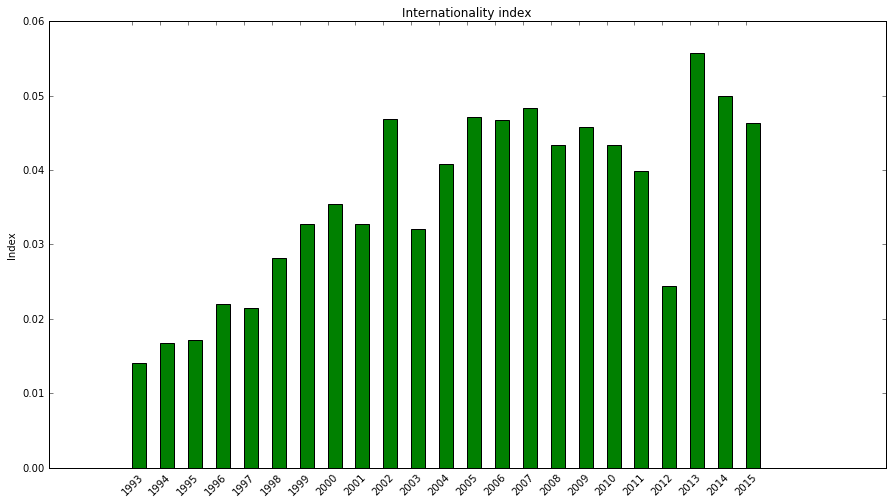

In [74]:
plt.figure(figsize=(15,8), dpi=80)
ind = np.arange(1993,2016)
open_measure_scaled.pop('0', None)
open_measure_scaled.pop('August 31-September 2 2005', None)
open_measure_scaled.pop('2017', None)
normalize_dict(open_measure_scaled)
tuples_pr = open_measure_scaled.items()
sort = sorted(tuples_pr, key = getKey)
x = [int(i[0]) for i in sort[-24:-1]]
y = [i[1] for i in sort[-24:-1]]
plt.bar(x, y, 0.5, color='g')

plt.ylabel('Index')
plt.title("Internationality index")
plt.xticks(ind, np.arange(1993,2016), rotation = 45)
#plt.yticks(np.arange(0, 2900, 300))
plt.savefig('internationality.png', dpi=100)

As a comment of our results, we can see that EPFL is enclined to work more and more with other universities. We had a lot of remarks concerning the abrupt drop of our internationality measure in 2012. Our strongest lead is the 2012 immigration referendum which may have provoked a boycott of EPFL by the international research community.

In [75]:
lab = pickle.load(open('author_lab.p', 'rb'))

### Community detection

#### Adding some useful statistics to the nodes in the graph
###### If you run from scratch and there are no precomputed files run following cells skip loading graph agian in next section, otherwise start in the next section

In [72]:
graph = graph_processing.load_graph('graph.json', 'JSON')

In [73]:
# it takes approximately 10 minutes using 8 cores
graph, degree_nodes, eigenvector_nodes, betweenness_nodes = graph_processing.add_centrality_stats(graph)

In [74]:
graph_processing.save_graph(graph, 'graviz/graph_centrality_serialized.json', 'JSON')

#### We load the graph in which the nodes are the authors of the papers and the edges represent the relation of collaboration between them.

In [75]:
graph = graph_processing.load_graph('graviz/graph_centrality_serialized.json', 'JSON')

#### First of all we compute some graph measures and store those information in the nodes.

We compute eigenvector centrality measure in order to rank the nodes and select the most important ones.

In [76]:
eigenvector_nodes = nx.get_node_attributes(graph, 'eigenvector_centrality')

And also we compute the betweenness centrality measure to see where are the authors that are most important for their communities.

In [77]:
betweenness_nodes = nx.get_node_attributes(graph, 'betweenness_centrality')

In order to visualize the graph we trim the nodes leaving top 2500.

In [78]:
graph = graph_processing.reduce_graph_size(graph, eigenvector_nodes, threshold=2500)

We print some statistics about the trimmed graph.

In [79]:
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 2500
Number of edges: 17492
Average degree:  13.9936


Now we want to run Louvain algorithm to detect the communities. First we need to find the matching between the authors and the schools. Later on we display the communities found by algorithm. Next we compare the results with the proper assignment taking schools as communities.

In [82]:
dict_lab_school = {}
for school in list_schools:
    dict_lab_school = {**dict_lab_school, **school_lab(dict_lab_site, school)}

In [83]:
author_lab = pickle.load(open('author_lab.p', 'rb'))

In [84]:
dict_schools = {'ENAC':1, 'SB':2, 'IC':3, 'STI':4, 'SV':5}

In [85]:
authors = nx.get_node_attributes(graph, 'author_id')

We collect the information about authors belongings to different schools. We assign number `0` to authors not connected with any of them.

In [86]:
proper_values = []
for node in graph.nodes():
    try:
        proper_values += [dict_schools[dict_lab_school[author_lab[authors[node]]]]]
    except:
        proper_values += [0]

In [87]:
parts = com.best_partition(graph)

In [88]:
values = [parts.get(node) for node in graph.nodes()]

We compute the layout of the nodes of the graph placing those belonging to one community close to each other and displaying the communities on the spiral.

In [89]:
nodes_positions = nx.spring_layout(graph)

In [90]:
nodes_positions_mod = nodes_positions
max_label = max(values)

In [91]:
# parameters for community shift
#r = 1
a = 0.6
b = 0.85
for key in nodes_positions_mod:
    # circle or elipse placement
    #nodes_positions_mod[key] += [r/2 * np.cos(2.0 * np.pi * parts[key] / max_label), r * np.sin(2.0 * np.pi * parts[key] / max_label)]
    # logarithmic spiral placement
    nodes_positions_mod[key] += [a * np.exp(b * (1 - parts[key] / max_label)) * np.cos(2.0 * np.pi * (1 - parts[key] / max_label)), a * np.exp(b * (1 - parts[key] / max_label)) * np.sin(2.0 * np.pi * (1 - parts[key] / max_label))]

This graph shows the communities found by Louvain algorithm.

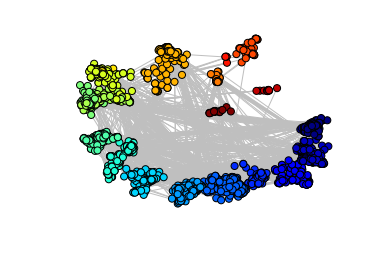

In [21]:
plt.axis("off")
nx.draw_networkx(graph, pos=nodes_positions_mod, cmap=plt.get_cmap("jet"), node_color=values, edge_color=['0.75'] * len(graph.edges()), node_size=50, with_labels=False)
plt.savefig("Images/communities_found.png", format="PNG", dpi=300)

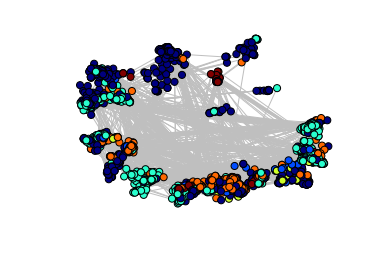

In [22]:
plt.axis("off")
nx.draw_networkx(graph, pos=nodes_positions_mod, cmap=plt.get_cmap("jet"), node_color=proper_values, edge_color=['0.75'] * len(graph.edges()), node_size=50, with_labels=False)
plt.savefig("Images/communities_proper.png", format="PNG", dpi=300)

From this visualization we can clearly see that there are many mixed communities. There is an interaction between reseachers from different schools. We can observe that the "old-school" division of EPFL is not accurate anymore. Probably it might be improved taking into account the existing collaborations between the labs and following the intrest of authors.

### Wordclouds

In [95]:
# We built three different dictionary that may be used later. The function documentation provides informations about
dict_lab_site, dict_labs, dict_labs_paper = lab_dictionaries(data_cut)

In [96]:
list_schools = ['ENAC', 'SB', 'IC', 'STI', 'SV']
dict_lab_school = {}
for school in list_schools:
    dict_lab_school = {**dict_lab_school, **school_lab(dict_lab_site, school)}

In [97]:
def concat_words(keywords):
    text = ' '.join([i for i in keywords])
    words = text.split(' ')
    return ' '.join([word for word in words if len(word) > 2])

switzerland_mask = imread('Images/switzerland_mask.png')
black_circle = imread('Images/black_circle.png')

In [98]:
# Get keywords from papers pubished between 1960 and 2017
keywords_all_time = wordclouds.get_keywords_by_years(data, 1960, 2017)
keywords_all_time = concat_words(keywords_all_time)

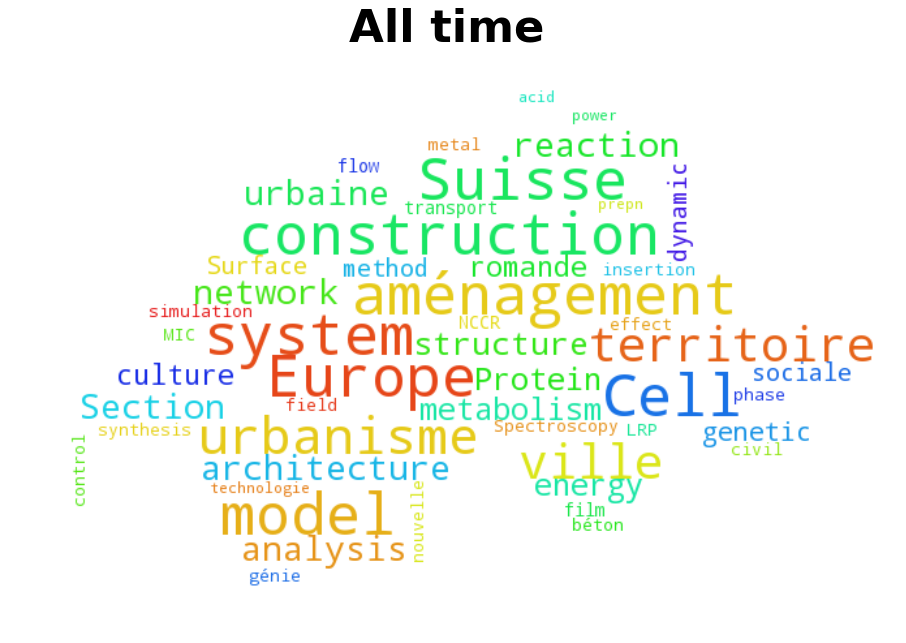

In [99]:
# Generate the word cloud
wordcloud = WordCloud(background_color="white", mask=switzerland_mask, max_font_size=45, random_state=42, max_words=50, width=3200, height=1800)
wordcloud.generate(keywords_all_time)

# Display the generated cloud
plt.figure(figsize=(20,10)).suptitle("All time", fontsize=45, fontweight='bold')
plt.imshow(wordcloud, cmap=plt.cm.gray)
plt.axis("off")
plt.savefig('Images/All_time.png', format="PNG", dpi=300)
plt.show()

We observe that thoughout the history EPFL the most popular keywords are associated with topic of civil engineering and architure. It is an expected result. We have seen before in the visualization of schools activity that ENAC is the most productive school.

In [100]:
# Get keywords from papers pubished in consecutive decades
keywords = [[wordclouds.get_keywords_by_years(data, 1960 + 10 * i, 1960 + 10 * (i + 1))] for i in range(6)]
keywords = [list(map(concat_words, k)) for k in keywords]

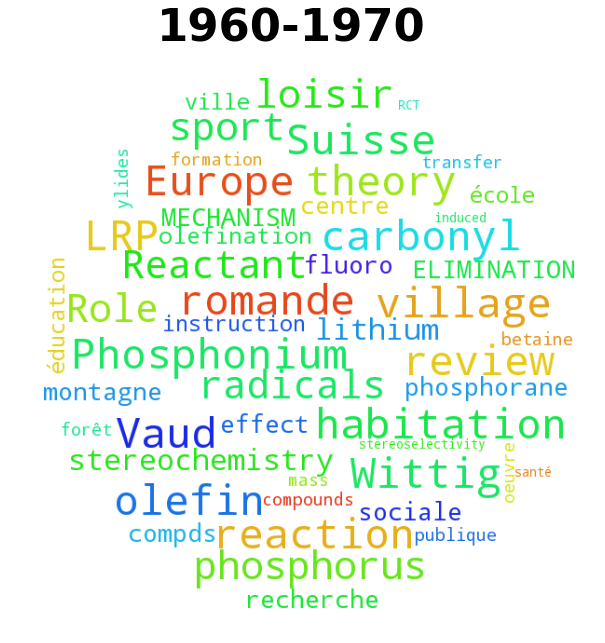

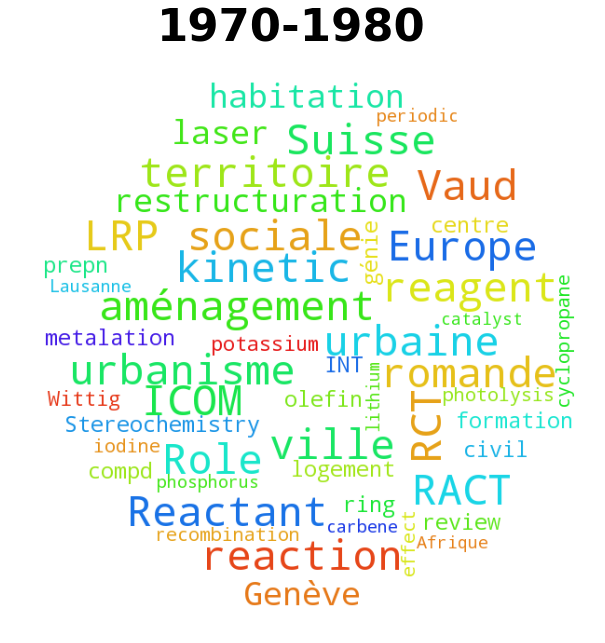

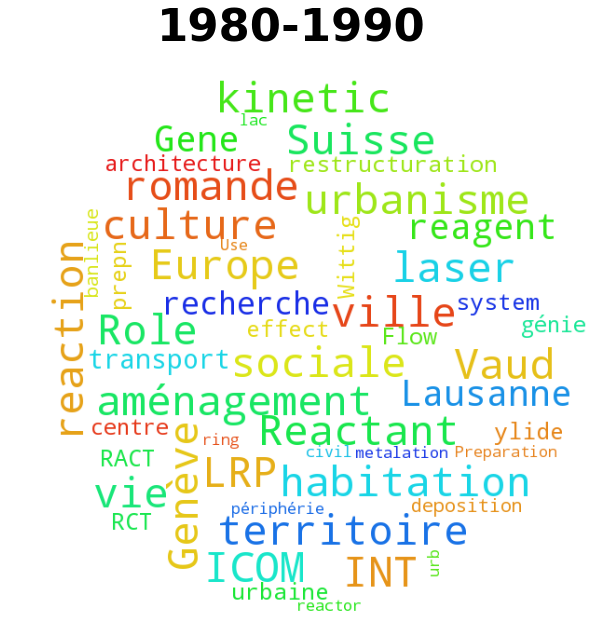

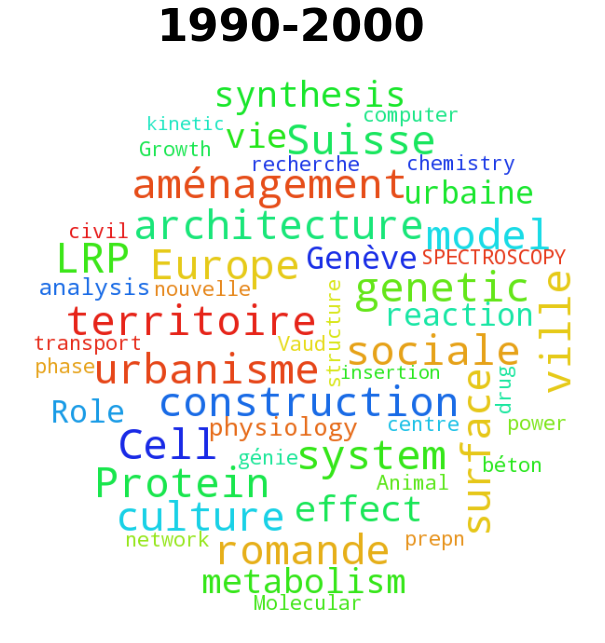

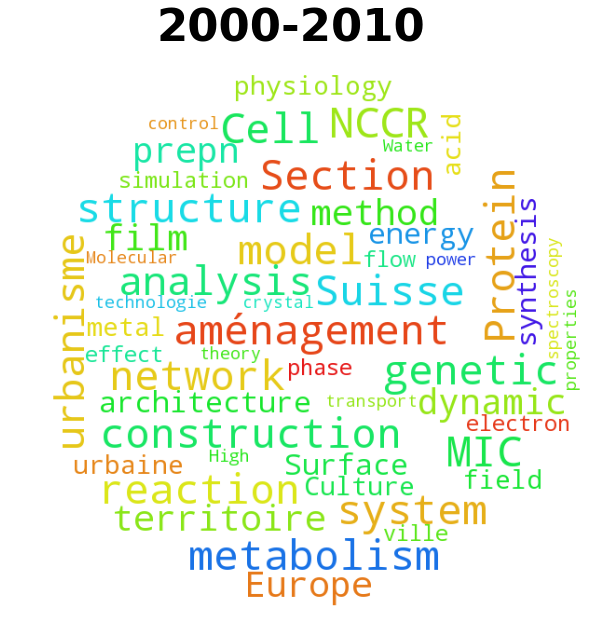

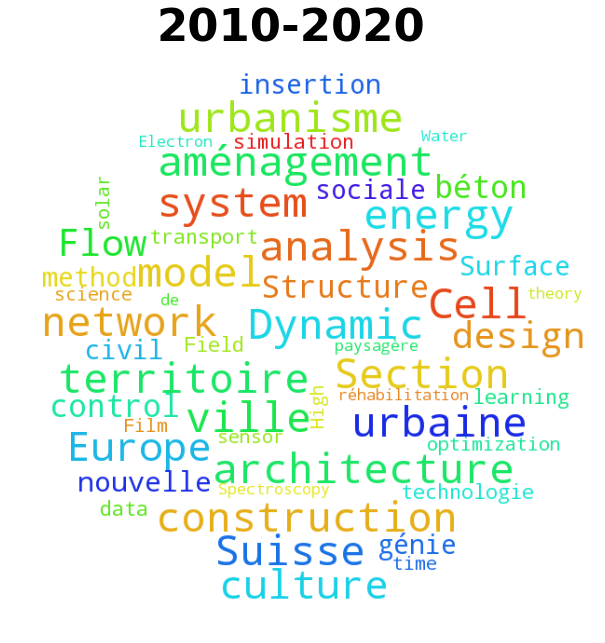

In [101]:
# Generate the word cloud
for i, k in enumerate(keywords):
    wordcloud = WordCloud(background_color="white", mask=black_circle, max_font_size=45, random_state=42, max_words=50, width=3200, height=1800)
    wordcloud.generate(k[0])
    
    # Display the generated cloud
    title = str(1960 + 10 * i) + '-' + str(1960 + 10 * (i + 1))
    plt.figure(figsize=(20,10)).suptitle(title, fontsize=45, fontweight='bold')
    plt.imshow(wordcloud, cmap=plt.cm.gray)
    plt.axis("off")
    plt.savefig('Images/' + title + '.png', format="PNG", dpi=300)
    plt.show()

In [102]:
# Get keywords from papers pubished in consecutive decades
keywords = [(wordclouds.get_keywords_by_school(data, dict_lab_school, school), school) for school in list_schools]
keywords = [(' '.join([i for i in (' '.join(k[0]).split(' ')) if len(i) > 2]), k[1]) for k in keywords]

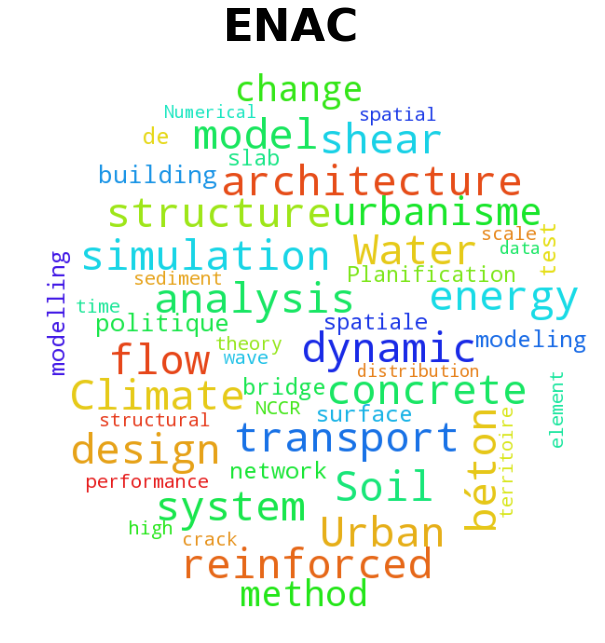

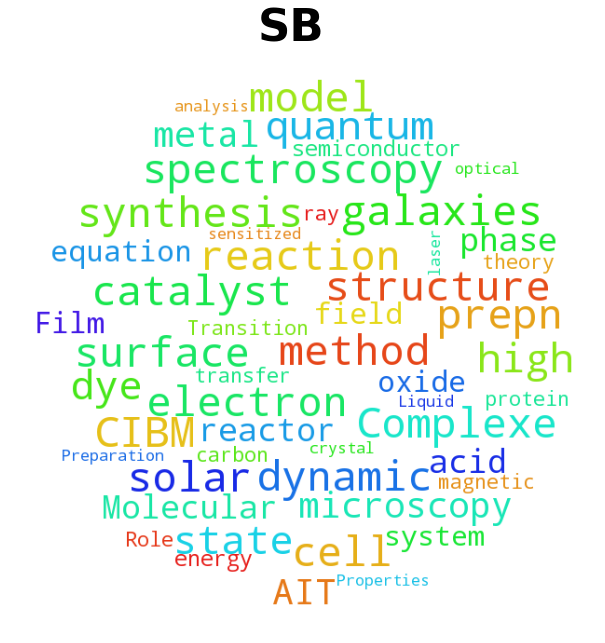

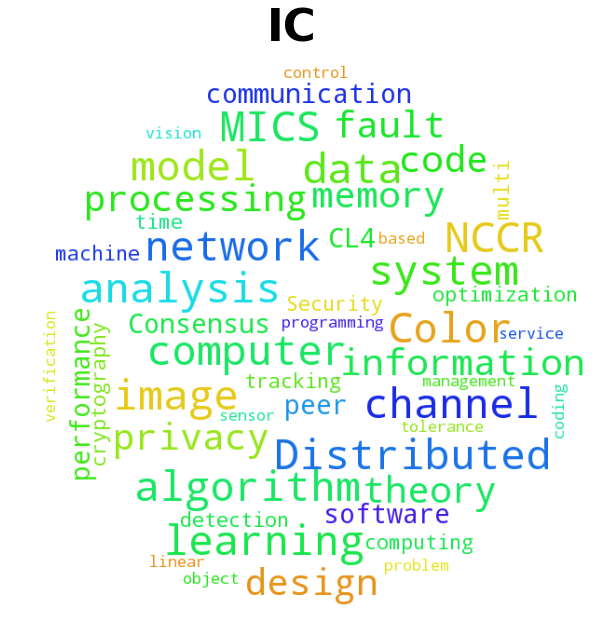

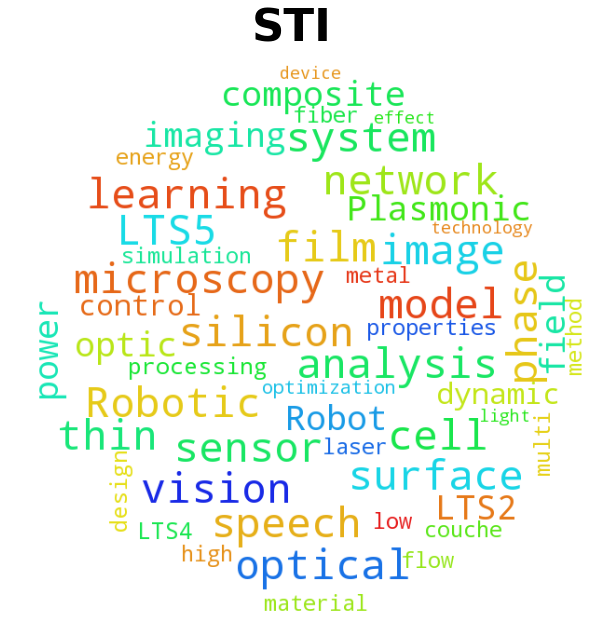

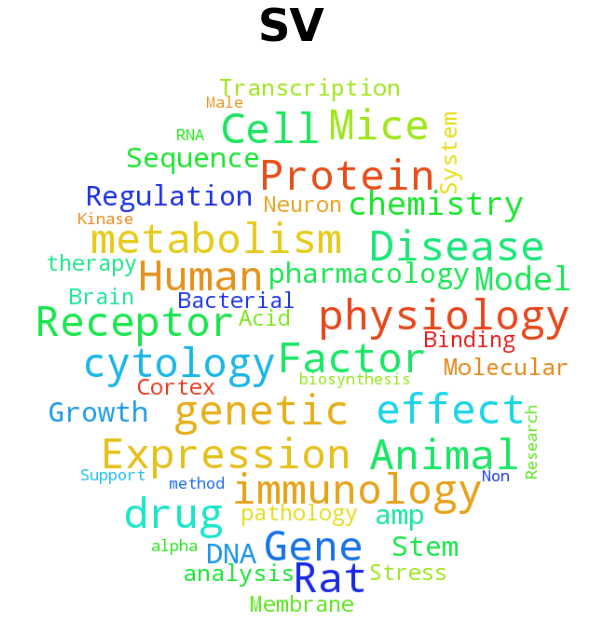

In [103]:
# Generate the word cloud
for i, k in enumerate(keywords):
    wordcloud = WordCloud(background_color="white", mask=black_circle, max_font_size=45, random_state=42, max_words=50, width=3200, height=1800)
    wordcloud.generate(k[0])
    
    # Display the generated cloud
    title = str(k[1])
    plt.figure(figsize=(20,10)).suptitle(title, fontsize=45, fontweight='bold')
    plt.imshow(wordcloud, cmap=plt.cm.gray)
    plt.axis("off")
    plt.savefig('Images/' + title + '.png', format="PNG", dpi=300)
    plt.show()

### EPFL Map

Previously, we have seen that the schools of EPFL tend to collaborate a lot and that such traditional organization of research may not be optimal. In order to further reinforce our claim, we would like to see if the layout is optimal, well organized for providing the best environment for research. Our idea is to design a spatial score function in order to assess the quality of the EPFL spatial organization.

We want a recent "état des lieux" of the EPFL layout, we only consider the last 3 years.

In [76]:
#Create a dictionnary for the last years.
data_cut = {}
for paper in list(data.keys()):
    try:
        if int(data[paper]['Publication date']) == 2014:
            data_cut[paper] = data[paper]
    except:
        continue

In [77]:
#Create several dictionaries for school, localization and papers, see helper function in separate file.
dict_lab_site, dict_labs, dict_labs_paper = lab_dictionaries(data_cut)

The idea now is to count the collaborations for every pair of schools/labs, for that we'll use a graph with school/labs as nodes and collaboration as weighted edges

In [78]:
# Dictionary (lab, id)
dict_lab_id = {}
for  id_,lab in enumerate(list(dict_labs_paper.keys())):
    dict_lab_id[lab] = id_
    
dict_id_lab = {v: k for k, v in dict_lab_id.items()}

Build the graph

In [79]:
# Define edges of the graph: labs that writes papers together
# Dictionary (Lab, dict(lab, publication together))
dict_edges = {}
for lab in list(dict_labs_paper.keys()):
    dict_edges[lab] = defaultdict(list) 
    for lab_2 in list(dict_labs_paper.keys()):
        if lab_2 != lab:
            list_intersection = [p for p in dict_labs_paper[lab] if p in dict_labs_paper[lab_2]]
            if len(list_intersection) != 0:
                dict_edges[lab][lab_2] += list_intersection
            #dict_edges[lab_2][lab] += [p for p in dict_labs_paper[lab] if p in dict_labs_paper[lab_2]]

We now have to link each lab with its school in order to get a global view of the situation. A more fine grained approach would have been to scrap each lab's location and have a node/score for each one of them. This task only represents a big workload overhead, therefore, we'll stick with the less precise approach and compute everything according to schools.

In the next step we link each schools to its labs.

In [80]:
school_lab_dict = {}
for school in list_schools:
    school_lab_dict.update(school_lab(dict_lab_site, school))

In [81]:
# Get the list of edges and weigths for the edges
edges = []
weigths = {}
for lab in dict_edges:
    if len(dict_edges[lab]) != 0:
        for lab_2 in dict_edges[lab]:
            edges += sorted([(dict_lab_id[lab], dict_lab_id[lab_2])])
            weigths[(dict_lab_id[lab], dict_lab_id[lab_2])] = len(dict_edges[lab][lab_2])

In [82]:
dict_school_pub_edges = defaultdict(int)
for edge in list(weigths.keys()):
    try:
        dict_school_pub_edges[school_lab_dict[dict_id_lab[edge[0]]], school_lab_dict[dict_id_lab[edge[1]]]] += weigths[edge]
    except:
        continue

* A glimpse at the number of labs per school.

In [83]:
counter=collections.Counter(list(school_lab_dict.values()))

In [84]:
counter

Counter({'ENAC': 51, 'IC': 31, 'SB': 44, 'STI': 52, 'SV': 13})

Remove self pointing edges.

In [85]:
# Exlude collaborations between same school
for key in list(dict_school_pub_edges.keys()):
    if key[0] == key[1]:
        del dict_school_pub_edges[key]

In [86]:
total_paper = sum(list(dict_school_pub_edges.values()))

* Let's get a look at the collaborations between schools :

In [87]:
# Collaborations inter schools
dict_inter_school_pub = defaultdict(int)
for key in list(dict_school_pub_edges.keys()):
    pair_school = tuple(sorted([key[0], key[1]]))
    dict_inter_school_pub[pair_school] += dict_school_pub_edges[key]/total_paper

In [88]:
dict_inter_school_pub

defaultdict(int,
            {('ENAC', 'IC'): 0.19298245614035087,
             ('ENAC', 'SB'): 0.10526315789473684,
             ('ENAC', 'STI'): 0.24561403508771928,
             ('ENAC', 'SV'): 0.03508771929824561,
             ('IC', 'SB'): 0.03508771929824561,
             ('IC', 'STI'): 0.03508771929824561,
             ('IC', 'SV'): 0.03508771929824561,
             ('SB', 'STI'): 0.21052631578947367,
             ('SB', 'SV'): 0.03508771929824561,
             ('STI', 'SV'): 0.07017543859649122})

Here we can already look at interesting results i.e. which schools collaborate the most. The best collaboration happens between ENAC and STI school.

For the next step we'll prepare the EPFL map and overlay our score metric.

First we initialize the school centers, representing the position of each school within EPFL.

In [89]:
#Initialize school centers
X_1 = 532700
X_2 = 533507
Y_1 = 152693
Y_2 = 152242

In [90]:
#Scale
X_1_scaled = 0
X_2_scaled = 807
Y_1_scaled = 451
Y_2_scaled = 0

In [91]:
# Scaled coordinates
coordinate_ENAC = (152571-Y_2, 533078- X_1)
coordinate_IC = (152292-Y_2, 532818- X_1, )
coordinate_SV = (152457-Y_2, 532815- X_1)
coordinate_SB = (152526-Y_2, 533263- X_1)
coordinate_STI = (152399-Y_2, 532938- X_1)

In [92]:
dict_school = {list_schools[i]:i+1 for i in range(len(list_schools))}

We discretize the EPFL map in a grid in order to be able to assign score values to each cell.

In [93]:
# Create the grid 451 x 807 each patch is 1x1
empty_map = np.zeros((451,807))

In [94]:
ranges_X = np.arange(X_1_scaled, X_2_scaled, 1)
ranges_Y = np.arange(Y_2_scaled, Y_1_scaled, 1)

Place the school centers in the grid.

In [95]:
school_center_map = {'ENAC': coordinate_ENAC, 'IC':coordinate_IC, 'SV':coordinate_SV, 'SB':coordinate_SB, 'STI':coordinate_STI}

In [96]:
dict_coordinates = {'ENAC': coordinate_ENAC, 'IC':coordinate_IC, 'SV':coordinate_SV, 'SB':coordinate_SB, 'STI':coordinate_STI}

Compute the distance between each pair of school, we'll use this as a penalty for schools that collaborate a lot.

In [97]:
# Define distances between points
import math
dict_distances = defaultdict(int)
for school in list(dict_coordinates.keys()):
    for school_1 in list(dict_coordinates.keys()):
        if school != school_1:
            dict_distances[(school, school_1)] = math.sqrt( (school_center_map[school][0] - school_center_map[school_1][0])**2 + (school_center_map[school][1] - school_center_map[school_1][1])**2 )

In [98]:
dict_distance_inter_school = defaultdict(int)
for key in list(dict_distances.keys()):
    pair_school = tuple(sorted([key[0], key[1]]))
    dict_distance_inter_school[pair_school] += dict_distances[key]

#### Define the score function
   $$QP_u = \sum_{v}[ (1-\theta_{uv}) \times||(u,v)||^2_2]$$
   
where:

* $QP_u$: quality position of the school $u$
* $\theta_{uv}$: is the proportion of work produced by both u and v over the number of all publication between two schools

Thus, greater $QP4 is better is positioned the school according to its research contribution.

Define score function variables.

In [99]:
# 2014
dict_theta = {}
for pairs in list(dict_distances.keys()):
    dict_theta[(pairs[0],pairs[1])] = dict_inter_school_pub[pairs]
    dict_theta[(pairs[1],pairs[0])] = dict_inter_school_pub[pairs]

Compute score function nominator for each school.

In [100]:
dict_index = {}
list_index = []
for pairs in list(dict_distances.keys()):
    list_index += [dict_distances[pairs] * (1-dict_theta[pairs])]
    dict_index[pairs] = dict_distances[pairs] * (1-dict_theta[pairs])

Compute score for each school.

In [101]:
qp_dictionary = {}
for school in list_schools:
    list_school_score = [dict_index[key] for key in list(dict_distances.keys()) if key[0] == school]
    qp_dictionary[school] = sum(list_school_score)/4#/denominator

In [102]:
qp_dictionary

{'ENAC': 233.01774321672593,
 'IC': 282.6764082091814,
 'SB': 368.83531478208477,
 'STI': 199.45430108474372,
 'SV': 257.8500016515966}

Helper function for spatial diffusion of the score, we'll use a Gaussian neighborhood.

In [103]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

Pack everything together, put the centers in the map diffuse and average the scores.

In [104]:
epfl_map =np.zeros((451,807))
#x,y center position
size_x, size_y = 451,807
#score ; score of the center
sigma_school = dict_coordinates = {'ENAC': 60, 'IC':40, 'SV':40, 'SB':50, 'STI': 40}
#Modify map according to the center score
for school in list(school_center_map.keys()):
    for i in range(size_x):
        for j in range(size_y):
            #calculate gaussian distr sigma is space factor
            disc = gauss(np.sqrt(((size_x - school_center_map[school][0])-i)**2+((school_center_map[school][1])-j)**2),[0, 2*sigma_school[school]])
            epfl_map[i][j] += disc*qp_dictionary[school]

Plot the map.

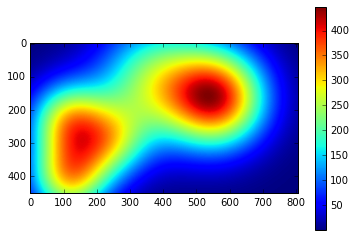

In [106]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import griddata
epfl_grey = mpimg.imread('map_school.png')
plt.imshow(epfl_map)
#plt.imshow(epfl_grey, alpha = 0.3)
plt.colorbar()
plt.show()
#plt.imsave('plot_map.png')

As a comment for our result here, we see that the score function yields two clusters, where Schools are collaborating very well. Nevertheless these components are disconnected which is a bad sign of spatial discrimination. The ideal layout would have been a more uniform repartition of the scores, therefore not discriminating any research community by its spatial location. This results shows us that when Schools are close there are a lot of collaborations. As a next step, we could devise an algorithm that would find the optimal layout for EPFL. We could also refine the result we just obtained by using labs instead of schools.